In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as siw
from playsound import playsound

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
data_path = [
    "./data/speechB1.wav",
    "./data/speechB2.wav",
    "./data/speechB3.wav",
]
data_list = []
fs_list = []
for p in data_path:
    fs, data = siw.read(p)
    fs_list.append(fs)
    data_list.append(data.copy())

data_arr = np.array(data_list)
print(f"number of data = {data_arr.shape[0]}")
print(f"length of each data = {data_arr.shape[1]}")


number of data = 3
length of each data = 112013


In [3]:
# speechB1
playsound("./data/speechB1.wav")

In [4]:
# speechB2
playsound("./data/speechB2.wav")


In [5]:
# speechB3
playsound("./data/speechB3.wav")


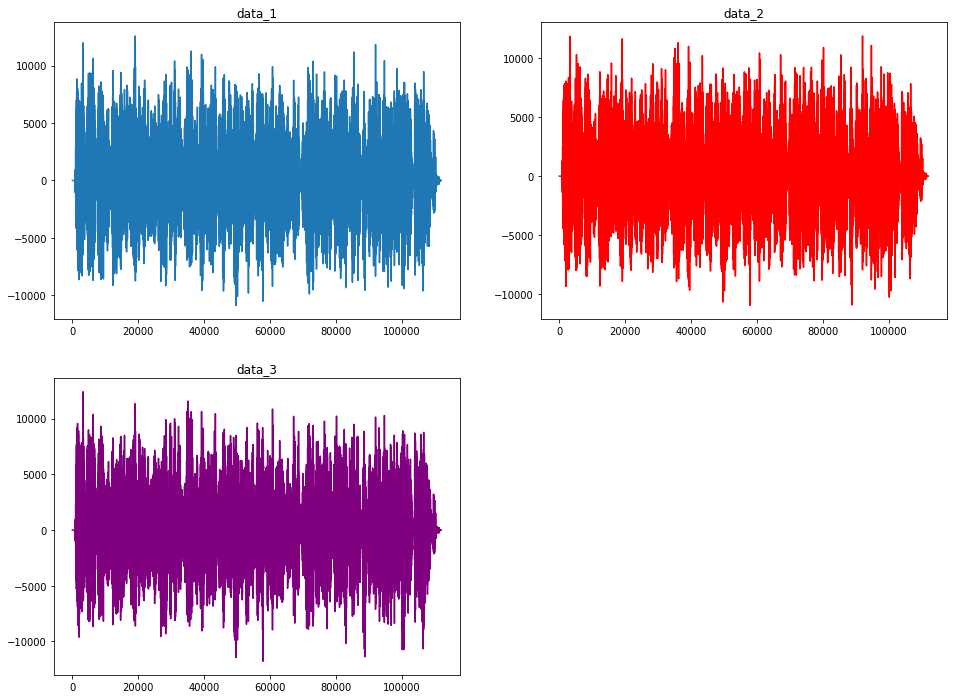

In [6]:
# plot
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax1.plot(data_arr[0])
ax1.set_title("data_1")
ax2.plot(data_arr[1], color="red")
ax2.set_title("data_2")
ax3.plot(data_arr[2], color="purple")
ax3.set_title("data_3")
plt.savefig("./output/kadai02/speechB_before.png")
plt.show()


In [7]:
# 平均0になるように観測データを調整
X = np.zeros((data_arr.shape[1], 3))
X[:, 0] = data_arr[0] - data_arr[0].mean()
X[:, 1] = data_arr[1] - data_arr[1].mean()
X[:, 2] = data_arr[2] - data_arr[2].mean()

print(f"X.shape = {X.shape}")


X.shape = (112013, 3)


In [8]:
# 共分散行列
sigma = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        sigma[i, j] = np.mean(X[:, i] * X[:, j])
print(f"sigma.shape = ({sigma.shape[0]}, {sigma.shape[1]})")
sigma


sigma.shape = (3, 3)


array([[5419448.86347846, 5186497.26320269, 5216423.05093043],
       [5186497.26320269, 5275067.03680963, 5151720.14098495],
       [5216423.05093043, 5151720.14098495, 5339616.06800171]])

In [9]:
# 対角化
vals, vecs = np.linalg.eig(sigma)
print(f"vals shape = ({vals.shape[0]},)")
print(f"vecs shape = ({vecs.shape[0]}, {vecs.shape[1]})")

E = vecs.copy()
D_sqrt_inv = np.diag(1.0 / np.sqrt(vals))
print(f"D^(-0.5).shape = ({D_sqrt_inv.shape[0]}, {D_sqrt_inv.shape[1]})")
V = E.dot(D_sqrt_inv.dot(E.T))
Z = np.array([V.dot(X[i, :]) for i in range(X.shape[0])])
print(f"Z.shape = {Z.shape}")

print(Z.T.dot(Z) / Z.shape[0])


vals shape = (3,)
vecs shape = (3, 3)
D^(-0.5).shape = (3, 3)
Z.shape = (112013, 3)
[[ 1.00000000e+00  2.92430780e-13 -2.02032567e-13]
 [ 2.92430780e-13  1.00000000e+00 -9.99312939e-14]
 [-2.02032567e-13 -9.99312939e-14  1.00000000e+00]]


In [13]:
W = np.zeros((3, 3))
EPS = 1e-4
i = 0
while i < 3:
    print(f"i={i}")
    w = np.random.randn(3, 1) * 100
    w /= np.linalg.norm(w)
    for _ in range(10000):
        diff = w.copy()
        wz = np.array([np.dot(w.T, Z[i, :]) for i in range(Z.shape[0])])
        w = np.mean(Z * (wz**3), axis=0, keepdims=True).reshape(3, 1) - 3*w
        w /= np.linalg.norm(w)
        diff -= w.copy()
        if np.linalg.norm(diff) < EPS:
            break
    if i == 0:
        # 最初の復元は必ず採用
        W[i, :] = np.copy(w.T)
        i += 1
        continue
    is_all_different = True
    for j in range(i):
        if np.linalg.norm(W[j, :] - w.T) < 1:
            is_all_different = False
            break
    
    if is_all_different:
        # got new source
        W[i, :] = np.copy(w.T)
        i += 1


i=0
i=1
i=1
i=1
i=1
i=2
i=2


In [14]:
Y = np.array([W.dot(Z[i, :]) for i in range(Z.shape[0])])
print(f"Y.shape = {Y.shape}")


Y.shape = (112013, 3)


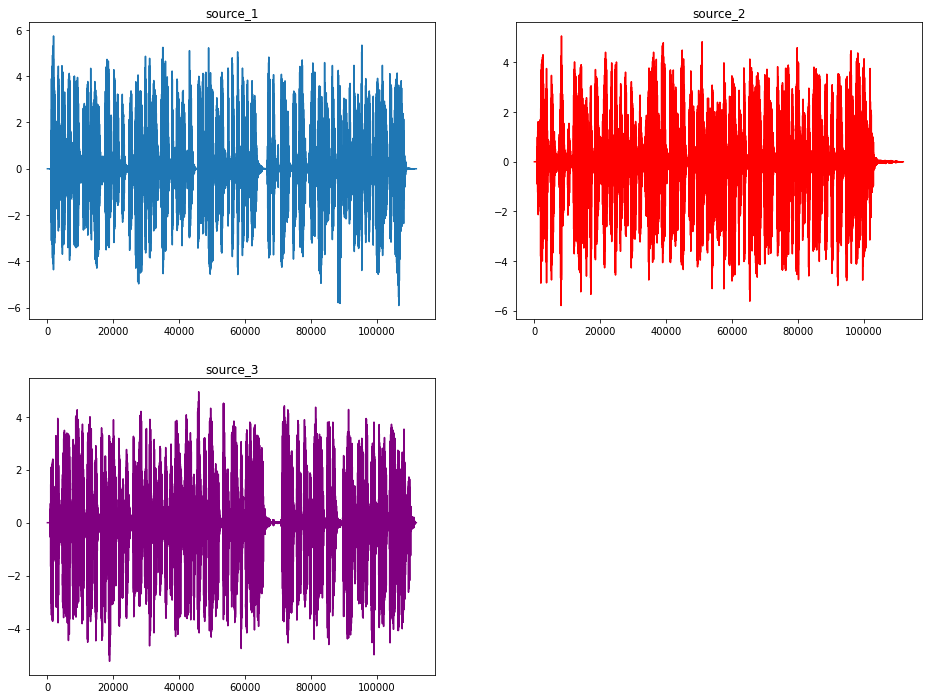

In [15]:
# plot
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax1.plot(Y[:, 0])
ax1.set_title("source_1")
ax2.plot(Y[:, 1], color="red")
ax2.set_title("source_2")
ax3.plot(Y[:, 2], color="purple")
ax3.set_title("source_3")
plt.savefig("./output/kadai02/speechB_after.png")
plt.show()


In [16]:
# save as wav
siw.write(filename="./output/kadai02/speechB_source1.wav",
          rate=fs_list[0], data=Y[:, 0])
siw.write(filename="./output/kadai02/speechB_source2.wav",
          rate=fs_list[1], data=Y[:, 1])
siw.write(filename="./output/kadai02/speechB_source3.wav",
          rate=fs_list[2], data=Y[:, 2])


In [17]:
# play source 1
playsound("./output/kadai02/speechB_source1.wav")

In [18]:
# play source 2
playsound("./output/kadai02/speechB_source2.wav")

In [19]:
# play source 3
playsound("./output/kadai02/speechB_source3.wav")
